In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import multinomial, beta, dirichlet
from scipy.integrate import cumtrapz
import statsmodels.stats.proportion

# progress bar
from tqdm import tqdm

import pandas as pd

plot_all_lines = False
import warnings
#warnings.simplefilter('error', RuntimeWarning)


import accuracy_analysis as aa

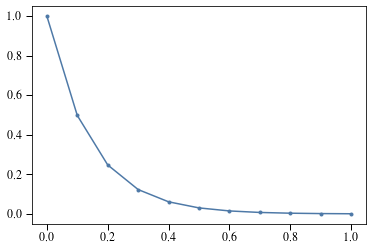

In [2]:
r_M, r_I, N_M = 0.8191511844812219, 0.5923916635105072, 0
N = 10
Ns = np.arange(0, N+1)
f_s = Ns/N
plt.figure()
Ltest = aa.L(Ns, r_M, r_I, N_M, N)
plt.plot(f_s, Ltest, '.-')
Ns = np.arange(N+1)

# A consistency check

Pretend first that there are separate processes, where someone shows you a group of mergers, and another where someone shows you a group of isolated galaxies. Given $N_M$ mergers and an accuracy of measuring $r_M$, the probability that you would say there are $\hat N_{M,1}$  galaxies in this sample is
$$
P(\hat N_{M,1}\mid r_M,N_M)=\binom{N_M}{\hat N_{M,1}}r_M^{\hat N_{M,1}}(1-r_M)^{N_M-\hat N_{M,1}}.
$$
Similarly, if someone showed you $N_I$ mergers and you accurately identified them accurately with a probability $r_I$, you would get $\hat N_{I,1}$ mergers correctly with probability
$$
P(\hat N_{I,1}\mid r_I,N_I)=\binom{N_I}{\hat N_{I,1}}r_I^{\hat N_{I,1}}(1-r_I)^{N_I-\hat N_{I,1}}
$$
However, we're interested in the number of isolated galaxies classified as mergers, $\hat N_{M,2}=N_I-\hat N_{I,1}$. We can write this as
$$
P(\hat N_{M,2}\mid r_I, N_I)=\binom{N_I}{N_I-\hat N_{M,2}}r_I^{N_I-\hat N_{M,2}}(1-r_I)^{\hat N_{M,2}}
$$

Text(0.5, 0, '$\\hat N_{M,2}$')

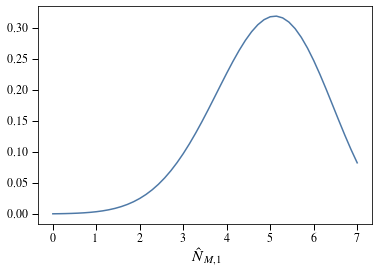

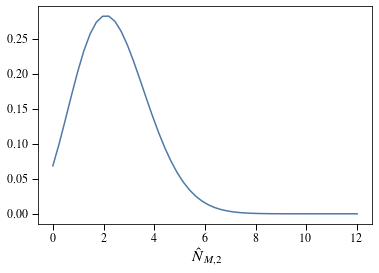

In [3]:
from scipy.special import binom
N_M = 7
N_I = 12
N_Mhats1 = np.linspace(0,N_M)
N_Mhats2 = np.linspace(0,N_I)
r_M = 0.7
r_I = 0.8
plt.figure()
plt.plot(N_Mhats1, binom(N_M, N_Mhats1)*r_M**N_Mhats1*(1-r_M)**(N_M-N_Mhats1))
plt.xlabel(r'$\hat N_{M,1}$')

plt.figure()
plt.plot(N_Mhats2, binom(N_I, N_I-N_Mhats2)*r_I**(N_I-N_Mhats2)*(1-r_I)**N_Mhats2)
plt.xlabel(r'$\hat N_{M,2}$')


Now of course, we are interested in the probability that we measure a total of $\hat N_M$ mergers given both of these processes, given a fixed number $N_M$ and $N_I$ of galaxies.

$\hat N_M=\hat N_{M,1}+\hat N_{M,2}$, and these processes happen simultaneously; therefore we want to do the "triangular" sum;

$$
P(\hat N_M\mid r_M,r_I,N_M,N_I)=
\sum_{\hat N_{M,1}+\hat N_{M,2}=\hat N_{M}}
P(\hat N_{M,1}\mid r_M,N_M)P(\hat N_{M,2}\mid r_I,N_I)
$$


Since $\hat N_{M,1}$ is the variable we are more interested in, we will make $\hat N_{M,2}$ a function of it. Also, there are strict limits on $\hat N_{M,1}$, e.g., it cannot be less than 0, or greater than $N_M$. The probability distribution then becomes
$$
P(\hat N_M\mid r_M,r_I,N_M,N_I)=
\sum_{\hat N_{M,1}=0}^{N_M}
P(\hat N_{M,1}\mid r_M,N_M)P(\hat N_M-\hat N_{M,1}\mid r_I,N_I)
$$

This curve seems reasonable. Its peak is at the sum of the peak locations for $\hat N_{M,1}$ and $\hat N_{M,2}$.

Now of course, in real life, we would rather have the probability distribution for $N_M$, and we are less interested in $N_I$, but we know that we have $N_\mathrm{tot}$ galaxies, so our probability distribution looks more like (substituting every $N_I\to N_\mathrm{tot}-N_M$)
$$
P(\hat N_M\mid r_M,r_I,N_M,N_\mathrm{tot})=
\sum_{\hat N_{M,1}=0}^{N_M}
P(\hat N_{M,1}\mid r_M,N_M)P(\hat N_M-\hat N_{M,1}\mid r_I,N_\mathrm{tot}-N_M)
$$

To get the posterior distribution, we assume a flat prior on $N_M$, and write
$$
P(N_M\mid\hat N_M,r_M,r_I,N_\mathrm{tot})
\propto P(\hat N_M\mid r_M,r_I,N_M,N_\mathrm{tot})P(N_M)
$$

To evaluate this function, we simply need to take the function above and keep $\hat N_M$ fixed while $N_M$ varies. In practice, we need to be a bit more careful.

$N_M$ can be anywhere from 0 to $N_\mathrm{tot}$. $\hat N_M$ is fixed, but $\hat N_{M,1}$ can vary. The limits of the sum remain the same.

So for each $N_M$, we get one number.

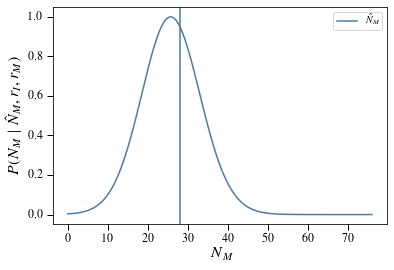

In [4]:
N_tot = 19*4
N_Ms = np.arange(0, N_tot+1)
N_Ms = np.linspace(0, N_tot,500)
P_arr = np.zeros(len(N_Ms))
N_Mhat = 7*4
P_arr = aa.L(N_Ms, r_I, r_M, N_Mhat, N_tot)
plt.plot(N_Ms, P_arr)
plt.xlabel(r'$N_M$')
plt.ylabel(r'$P(N_M\mid \hat N_M,r_I,r_M)$')
plt.axvline(N_Mhat, label=r'$\hat N_M$')
plt.legend(loc='best')

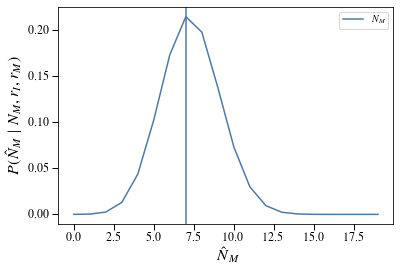

In [5]:
# What is the distribution of potential observations given a true value?

N_tot = 19
N_Mhats = np.arange(0, N_tot+1)
P_arr = np.zeros(len(N_Mhats))
N_M = 7
P_arr = [aa.P(N_Mhat, N_M, N_tot-N_M, r_I, r_M) for N_Mhat in N_Mhats]
plt.plot(N_Mhats, P_arr)
plt.xlabel(r'$\hat N_M$')
plt.ylabel(r'$P(\hat N_M\mid N_M,r_I,r_M)$')
plt.axvline(N_M, label=r'$N_M$')
plt.legend(loc='best')

flat chain shape: (601600, 29)
flat log prob shape: (601600,)


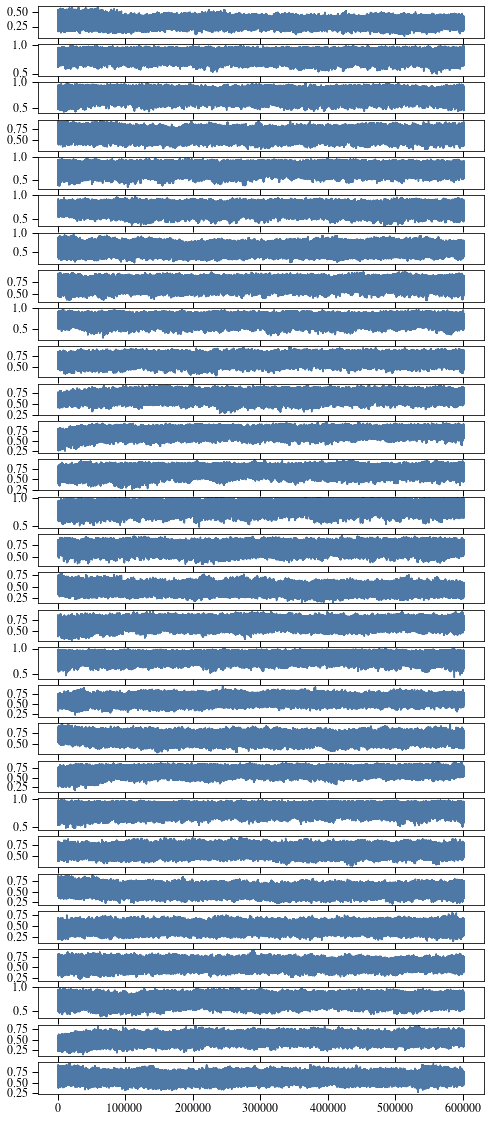

In [6]:
# What do the actual numbers look like?

import emcee

reader = emcee.backends.HDFBackend('prelim_results_largerun_v1.h5')

burnin = 300
thin = 0
samples = reader.get_chain(discard=burnin, flat=True)
log_prob_samples = reader.get_log_prob(discard=burnin, flat=True)


print("flat chain shape: {0}".format(samples.shape))
print("flat log prob shape: {0}".format(log_prob_samples.shape))

samples[:,0] /= 193

fig, axes = plt.subplots(figsize=(8, 20), nrows=29, ncols=1, sharex=True)
axs = axes.flatten()
for i in range(29):
    if i < 29:
        axs[i].plot(samples[:,i])
    else:
        axs[i].axis('off')

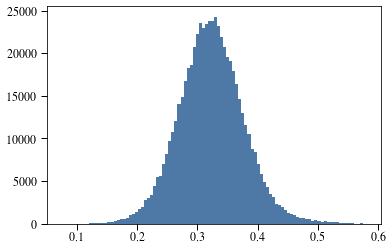

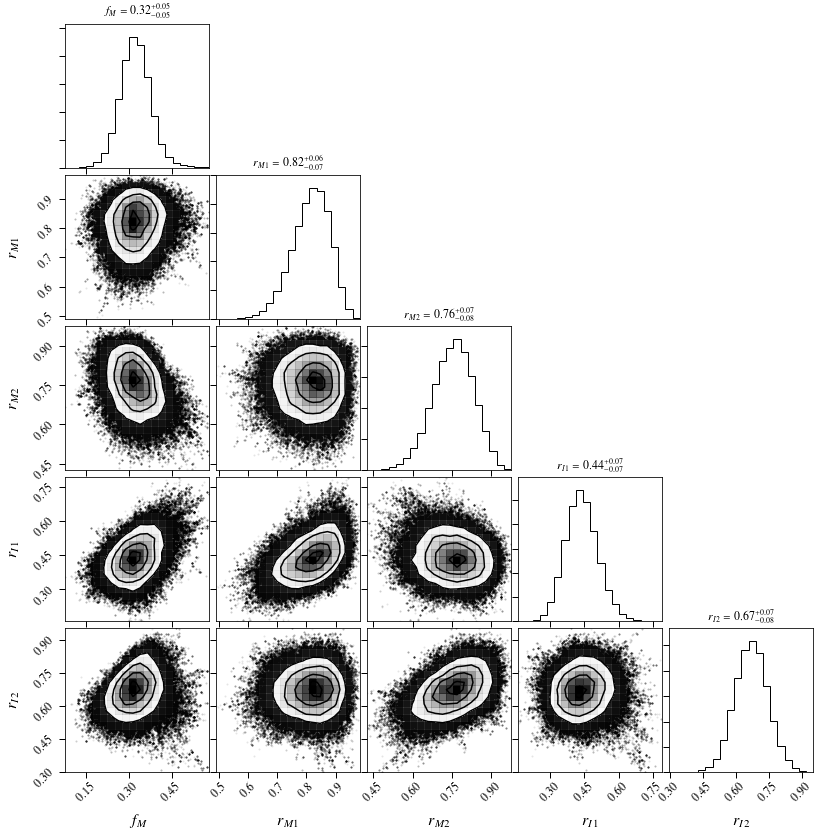

In [7]:
_=plt.hist(samples[:,0], 100)

n_poll = (len(samples[0]) - 1)//2
# first two people surveyed, so we just have 5 dimensions we're slicing through.
inds = [0, 1, 2, n_poll+1, n_poll+2]
samp = samples[:,inds]
labels = [r'$f_M$', r'$r_{M1}$', r'$r_{M2}$', r'$r_{I1}$', r'$r_{I2}$']

from corner import corner
fig = corner(samp, labels=labels, show_titles=True)
plt.savefig('corner_subset.pdf', bbox_inches='tight')

[0.05352814 0.06375766 0.0775789  0.08473024 0.08173612 0.07793302
 0.09342677 0.07742507 0.08013769 0.08139316 0.08077533 0.08235973
 0.07895831 0.07112882 0.07860877 0.07163735 0.07535555 0.064531
 0.07529676 0.07825713 0.07715368 0.06626631 0.07649408 0.08150268
 0.07379798 0.07551501 0.07865971 0.07560427 0.08087768]
[0.32319155 0.81387745 0.75405188 0.63139871 0.74790897 0.718947
 0.57257371 0.71113748 0.72128546 0.6738109  0.67987997 0.71136073
 0.69907548 0.85343747 0.69475807 0.4385333  0.67038377 0.82670765
 0.60666662 0.63385298 0.66712138 0.81613599 0.61572337 0.51696019
 0.45531673 0.56213001 0.71824734 0.51780107 0.61421667]


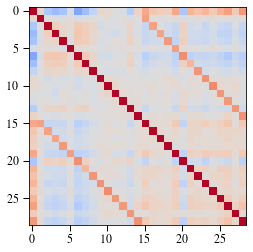

In [8]:
Cov_est = np.cov(samples.T)
D = np.diag(Cov_est)**0.5
plt.imshow(Cov_est/np.outer(D,D), vmin=-1, vmax=1, cmap='coolwarm')
print(D)
print(samples.mean(axis=0))

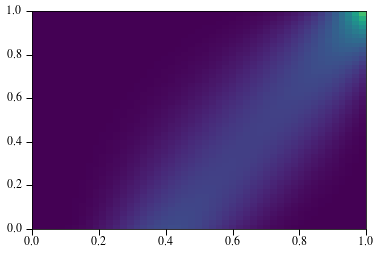

In [9]:
# Say we have observed 7 mergers and we were right. Let's see what the likelihood surface for r_M and r_I looks like.

r_Is = np.linspace(0,1)
r_Ms = np.linspace(0,1)
r_Is, r_Ms = np.meshgrid(r_Ms, r_Is)
N_Mhat = 7
N_M = 7
P_arr = np.zeros_like(r_Is)
for i in range(len(r_Is)):
    for j in range(len(r_Ms)):
        P_arr[i,j] = aa.P(N_Mhat, N_M, N_tot-N_M, r_Is[i,j], r_Ms[i,j])

plt.pcolormesh(r_Is, r_Ms, P_arr, vmin=0, vmax=1)

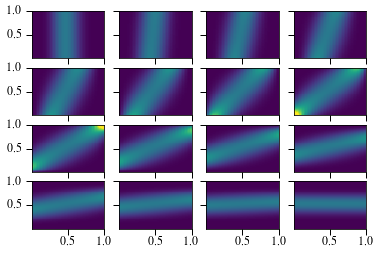

In [10]:
# This is a rough outline of what the likelihood looks like when you say you have measured 8 mergers.
# It is difficult to see what the relative heights are of the different N slices,
# but it does seem like there are peaks at r_M = 1 and r_I = 1 when N_M = N_hat.
fig, axes = plt.subplots(nrows=4, ncols=4, sharex=True, sharey=True)
axs = axes.flatten()
N_Ms = np.arange(16)
r_Is = np.linspace(0.01,1)
r_Ms = np.linspace(0.01,1)
r_Is, r_Ms = np.meshgrid(r_Ms, r_Is)
N_tot = 15
N_Mhat = 8
for n in range(len(N_Ms)):
    P_arr = np.zeros_like(r_Is)
    for i in range(len(r_Is)):
        for j in range(len(r_Ms)):
            P_arr[i,j] = aa.P(N_Mhat, N_Ms[n], N_tot-N_Ms[n], r_Is[i,j], r_Ms[i,j])
    axs[n].pcolormesh(r_Is, r_Ms, P_arr, vmin=0, vmax=0.5)

53.250237055042504 90.32625209751899 411.8773711743984 -153.16370626160312 72.65027225928478 -195.51581669396597
163.28539416598176 92.89763418802721 423.11832471954244 -264.88219404884103 126.15283908309127 -201.5594695257065
260.9153658668184 114.32221177662072 511.00318154698954 -345.8887655207254 167.08221845379788 -246.21056584016586
106.15739935397883 87.66796393649301 398.7926976602729 -208.43984248398505 99.19150358308038 -189.79684201578064
106.89153033693444 87.861009257999 398.7188243501194 -207.36686351429333 98.83968913566576 -189.98291480446517
49.84046969099154 85.8100525220884 386.2537971021673 -136.41010581419087 65.2751562335041 -184.49428178315037
343.87630660869917 116.35755964993777 524.3612338917458 -408.8529589575795 196.86423313215238 -252.20118483559872
95.93589856141449 86.80560822467598 393.96706167245554 -195.70122690093504 93.24418038392679 -187.65516424832742
28.984801293550078 81.76358701467379 369.6270202486218 -103.86440091254111 49.52576179440005 -176.

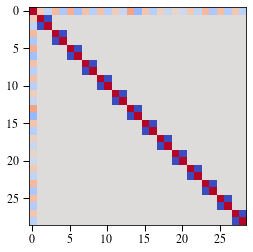

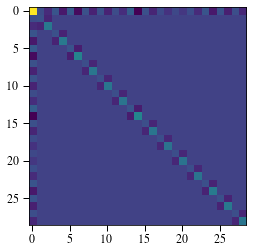

In [18]:
# With fixed observations \hat N_M, and a known N_M, r_Is, and r_Ms, we should be able to get the likelihood for each element of the Fisher matrix.

N_tot = 193
r_Ms = samples.mean(axis=0)[1:len(samples[0])//2+1]
r_Is = samples.mean(axis=0)[len(samples[0])//2+1:]

dr = 5e-3
df = 5e-3

f_M = samples.mean(axis=0)[0]
N_M = int(N_tot*f_M)


I = np.zeros((1+2*len(r_Ms),1+2*len(r_Ms)))


dr = 5e-3
df = 5e-3
dr2 = 6e-3

N_Mhat1 = r_Ms[0]*N_M + (1-r_Is[0])*(N_tot-N_M)
N_Mhat2 = r_Ms[1]*N_M + (1-r_Is[1])*(N_tot-N_M)
N_Mhats = [r_Ms[i]*N_M + (1-r_Is[i])*(N_tot-N_M) for i in range(len(r_Ms))]
for n in range(len(r_Ms)):
    Np = (f_M+df)*N_tot
    Nm = (f_M-df)*N_tot
    P_arr = aa.P(N_Mhats[n], N_M, N_tot-N_M, r_Is[n], r_Ms[n])
    f0 = np.log(P_arr)
        
    fp = np.log(aa.P(N_Mhats[n], Np, N_tot-Np, r_Is[n], r_Ms[n]))
    fm = np.log(aa.P(N_Mhats[n], Nm, N_tot-Nm, r_Is[n], r_Ms[n]))
    d2logPdf = (fp - 2*f0 + fm)/df**2
        
    fp = np.log(aa.P(N_Mhats[n], N_M, N_tot-N_M, r_Is[n]+dr, r_Ms[n]))
    fm = np.log(aa.P(N_Mhats[n], N_M, N_tot-N_M, r_Is[n]-dr, r_Ms[n]))
    d2logPdI = (fp - 2*f0 + fm)/dr**2
    
    fp = np.log(aa.P(N_Mhats[n], N_M, N_tot-N_M, r_Is[n], r_Ms[n]+dr))
    fm = np.log(aa.P(N_Mhats[n], N_M, N_tot-N_M, r_Is[n], r_Ms[n]-dr))
    d2logPdM = (fp - 2*f0 + fm)/dr**2
        
    # fI
    fpp = np.log(aa.P(N_Mhats[n], Np, N_tot-Np, r_Is[n]+dr, r_Ms[n]))
    fpm = np.log(aa.P(N_Mhats[n], Np, N_tot-Np, r_Is[n]-dr, r_Ms[n]))
    fmp = np.log(aa.P(N_Mhats[n], Nm, N_tot-Nm, r_Is[n]+dr, r_Ms[n]))
    fmm = np.log(aa.P(N_Mhats[n], Nm, N_tot-Nm, r_Is[n]-dr, r_Ms[n]))
    d2logPdfdI = (fpp - fpm - fmp + fmm)/(4*dr*df)
        
    # fM
    fpp = np.log(aa.P(N_Mhats[n], Np, N_tot-Np, r_Is[n], r_Ms[n]+dr))
    fpm = np.log(aa.P(N_Mhats[n], Np, N_tot-Np, r_Is[n], r_Ms[n]-dr))
    fmp = np.log(aa.P(N_Mhats[n], Nm, N_tot-Nm, r_Is[n], r_Ms[n]+dr))
    fmm = np.log(aa.P(N_Mhats[n], Nm, N_tot-Nm, r_Is[n], r_Ms[n]-dr))
    d2logPdfdM = (fpp - fpm - fmp + fmm)/(4*dr*df)
        
    # IM
    fpp = np.log(aa.P(N_Mhats[n], N_M, N_tot-N_M, r_Is[n]+dr, r_Ms[n]+dr2))
    fpm = np.log(aa.P(N_Mhats[n], N_M, N_tot-N_M, r_Is[n]+dr, r_Ms[n]-dr2))
    fmp = np.log(aa.P(N_Mhats[n], N_M, N_tot-N_M, r_Is[n]-dr, r_Ms[n]+dr2))
    fmm = np.log(aa.P(N_Mhats[n], N_M, N_tot-N_M, r_Is[n]-dr, r_Ms[n]-dr2))
    d2logPdIdM = (fpp - fpm - fmp + fmm)/(4*dr*dr2)

        
    I_ff = -d2logPdf
    I_MM = -d2logPdM
    I_II = -d2logPdI
    
    I_fI = -d2logPdfdI
    I_fM = -d2logPdfdM
    I_IM = -d2logPdIdM
    print(I_ff, I_MM, I_II, I_fI, I_fM, I_IM)
    I[0,0] += I_ff
    I[2*n+1,2*n+1] = I_MM
    I[2*n+2,2*n+2] = I_II
    
    I[2*n+1, 2*n+2] = I_IM
    I[2*n+2, 2*n+1] = I_IM
    
    I[0, 2*n+1] = I_fM
    I[2*n+1, 0] = I_fM
    I[0, 2*n+2] = I_fI
    I[2*n+2, 0] = I_fI

D = np.diag(I)
rho = I/np.outer(D,D)**0.5
plt.imshow(rho, vmin=-1, vmax=1, cmap='coolwarm')

plt.figure()
plt.imshow(I)

[[  80.00504087   84.12286406 -176.39935284]
 [  84.12286406   85.52717802 -184.62110146]
 [-176.39935284 -184.62110146  387.38692607]]


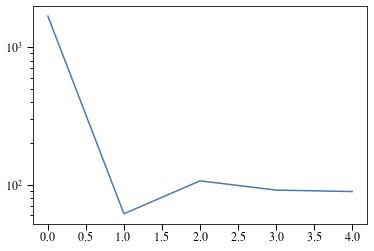

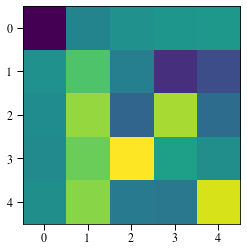

In [36]:
# for a single matrix, we have
I_test = np.array([
    [I_ff, I_fM, I_fI],
    [I_fM, I_MM, I_IM],
    [I_fI, I_IM, I_II]
])

print(I_test)
inds = np.array([0,1,2])
#np.linalg.cholesky(I_test[inds][:,inds])


inds = np.array([0,1,3,5,7])
l, w = np.linalg.eig(I[inds][:,inds])
plt.semilogy(l)
plt.semilogy(-l, 'C0--')

plt.figure()
plt.imshow(w)

/etc/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in log
/etc/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:36: RuntimeWarning: divide by zero encountered in log
/etc/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:52: RuntimeWarning: divide by zero encountered in log
/etc/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:68: RuntimeWarning: divide by zero encountered in log
/etc/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:84: RuntimeWarning: divide by zero encountered in log


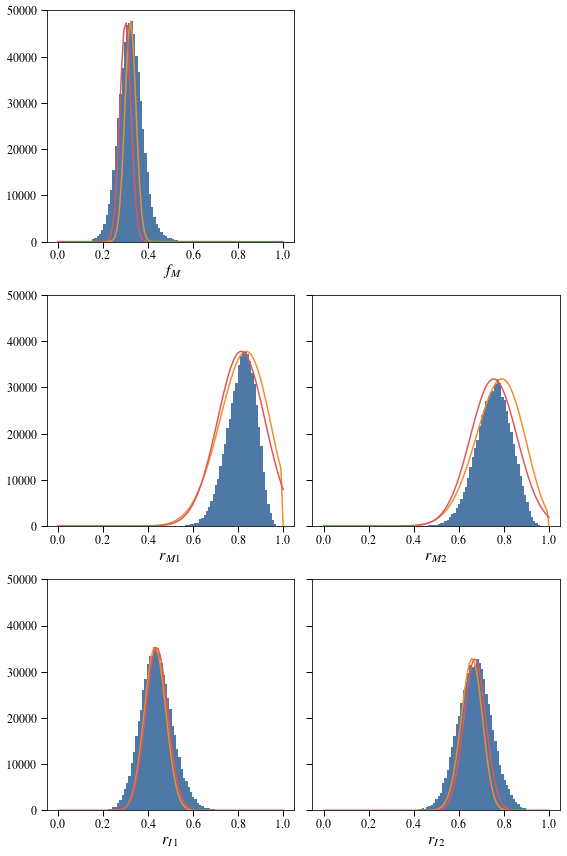

In [20]:
# Evaluate the likelihood keeping all parameters but one fixed....

f_Ms = np.linspace(0,1,100)

lnL = np.zeros(len(f_Ms))


for n in range(len(r_Ms)):
    for i in range(len(f_Ms)):
        P_arr = aa.P(N_Mhats[n], f_Ms[i]*N_tot, N_tot-f_Ms[i]*N_tot, r_Is[n], r_Ms[n])
        lnL[i] += np.log(P_arr)

fig, axes = plt.subplots(nrows=3, ncols=2, sharey=True, figsize=(8, 12))
axs = axes.flatten()

bins = np.linspace(0,1,100)
N, bin_edges, patches = axs[0].hist(samples[:,0], bins=bins)

axs[0].plot(f_Ms, max(N)*np.exp(lnL-max(lnL)))
axs[0].plot(f_Ms, max(N)*np.exp(-(f_Ms-0.3)**2*I[0,0]/2))


axs[0].set_xlabel(r'$f_M$')

f_M = 0.3
r_M1s = np.linspace(0,1,100)

lnL = np.zeros(len(r_M1s))

for n in range(len(r_Ms)):
    for i in range(len(r_M1s)):
        if n == 0:
            P_arr = aa.P(N_Mhats[n], f_M*N_tot, N_tot-f_M*N_tot, r_Is[n], r_M1s[i])
        else:
            P_arr = aa.P(N_Mhats[n], f_M*N_tot, N_tot-f_M*N_tot, r_Is[n], r_Ms[n])
        lnL[i] += np.log(P_arr)
N, bin_edges, patches = axs[2].hist(samples[:,1], bins=bins)
axs[2].plot(r_M1s, max(N)*np.exp(lnL-max(lnL)))
axs[2].plot(r_M1s, max(N)*np.exp(-(r_M1s-r_Ms[0])**2*I[1,1]/2))
axs[2].set_xlabel(r'$r_{M1}$')

r_M2s = np.linspace(0,1,100)

lnL = np.zeros(len(r_M2s))

for n in range(len(r_Ms)):
    for i in range(len(r_M2s)):
        if n == 1:
            P_arr = aa.P(N_Mhats[n], f_M*N_tot, N_tot-f_M*N_tot, r_Is[n], r_M2s[i])
        else:
            P_arr = aa.P(N_Mhats[n], f_M*N_tot, N_tot-f_M*N_tot, r_Is[n], r_Ms[n])
        lnL[i] += np.log(P_arr)
N, bin_edges, patches = axs[3].hist(samples[:,2], bins=bins)
axs[3].plot(r_M2s, max(N)*np.exp(lnL-max(lnL)))
axs[3].plot(r_M2s, max(N)*np.exp(-(r_M2s-r_Ms[1])**2*I[3,3]/2))
axs[3].set_xlabel(r'$r_{M2}$')

r_I1s = np.linspace(0,1,100)

lnL = np.zeros(len(r_M1s))

for n in range(len(r_Ms)):
    for i in range(len(r_M1s)):
        if n == 0:
            P_arr = aa.P(N_Mhats[n], f_M*N_tot, N_tot-f_M*N_tot, r_I1s[i], r_Ms[n])
        else:
            P_arr = aa.P(N_Mhats[n], f_M*N_tot, N_tot-f_M*N_tot, r_Is[n], r_Ms[n])
        lnL[i] += np.log(P_arr)
N, bin_edges, patches = axs[4].hist(samples[:,1+len(r_Ms)], bins=bins)
axs[4].plot(r_M1s, max(N)*np.exp(lnL-max(lnL)))
axs[4].plot(r_I1s, max(N)*np.exp(-(r_I1s-r_Is[0])**2*I[2,2]/2))
axs[4].set_xlabel(r'$r_{I1}$')

r_I2s = np.linspace(0,1,100)

lnL = np.zeros(len(r_M2s))

for n in range(len(r_Ms)):
    for i in range(len(r_M2s)):
        if n == 1:
            P_arr = aa.P(N_Mhats[n], f_M*N_tot, N_tot-f_M*N_tot, r_I2s[i], r_Ms[n])
        else:
            P_arr = aa.P(N_Mhats[n], f_M*N_tot, N_tot-f_M*N_tot, r_Is[n], r_Ms[n])
        lnL[i] += np.log(P_arr)
N, bin_edges, patches = axs[5].hist(samples[:,2+len(r_Ms)], bins=bins)
axs[5].plot(r_M2s, max(N)*np.exp(lnL-max(lnL)))
axs[5].plot(r_I2s, max(N)*np.exp(-(r_I2s-r_Is[1])**2*I[4,4]/2))
axs[5].set_xlabel(r'$r_{I2}$')

axs[1].axis('off')
plt.tight_layout()

plt.savefig('1d_slices.pdf', bbox_inches='tight')

In [15]:
# Want to compare the 2D slice f_M and r_M1.

f_Ms = np.linspace(0.2,0.4,100)
r_I1s = np.linspace(0.0,1,100)
f_Ms, r_I1s = np.meshgrid(f_Ms, r_I1s)

lnL = np.zeros_like(f_Ms)


for n in range(len(r_Ms)):
    for i in range(len(f_Ms)):
        for j in range(len(f_Ms[0])):
            if n == 0:
                P_arr = aa.P(N_Mhats[n], f_Ms[i,j]*N_tot, N_tot-f_Ms[i,j]*N_tot, r_I1s[i,j], r_Ms[n])
            else:
                P_arr = aa.P(N_Mhats[n], f_Ms[i,j]*N_tot, N_tot-f_Ms[i,j]*N_tot, r_Is[n], r_Ms[n])
            lnL[i,j] += np.log(P_arr)


/etc/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log


### bounds = np.linspace(0,1,5)
#sigmas = np.arange(6)
#bounds = 1 - np.exp(-sigmas**2/2)
#print(bounds)
from matplotlib import colors
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)


lnL[~np.isfinite(lnL)]= -np.inf
plt.pcolormesh(f_Ms, r_I1s, np.exp(lnL-lnL.max()), norm=norm)
plt.xlabel(r'$f_M$')
plt.ylabel(r'$r_{I1}$')
plt.colorbar()

/etc/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log


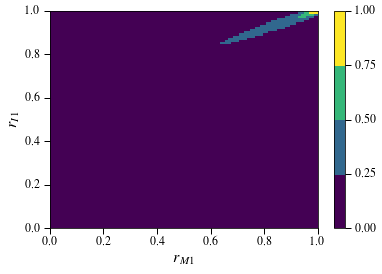

In [39]:
# Want to compare the 2D slice f_M and r_M1.
r_M1s = np.linspace(0.0,1,100)
r_I1s = np.linspace(0.0,1,100)
r_M1s, r_I1s = np.meshgrid(f_Ms, r_I1s)

lnL = np.zeros_like(r_M1s)

N_Mhats = np.zeros_like(N_Mhats) + f_M*N_tot

for n in range(len(r_Ms)):
    for i in range(len(r_M1s)):
        for j in range(len(r_M1s[0])):
            if n == 0:
                P_arr = aa.P(N_Mhats[n], f_M*N_tot, N_tot-f_M*N_tot, r_I1s[i,j], r_M1s[i,j])
            else:
                P_arr = aa.P(N_Mhats[n], f_M*N_tot, N_tot-f_M*N_tot, r_Is[n], r_Ms[n])
            lnL[i,j] += np.log(P_arr)
bounds = np.linspace(0,1,5)
#sigmas = np.arange(6)
#bounds = 1 - np.exp(-sigmas**2/2)
#print(bounds)
from matplotlib import colors
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)


lnL[~np.isfinite(lnL)]= -np.inf
plt.pcolormesh(r_M1s, r_I1s, np.exp(lnL-lnL.max()), norm=norm)
plt.xlabel(r'$r_{M1}$')
plt.ylabel(r'$r_{I1}$')
plt.colorbar()

-0.0451846692934492


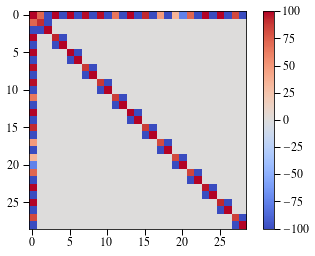

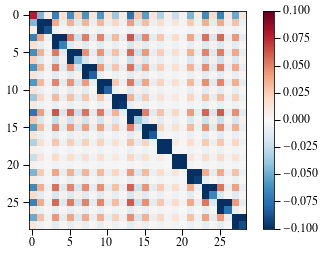

In [17]:
plt.figure()
plt.imshow(I, vmin=-100, vmax=100, cmap='coolwarm')
plt.colorbar()
plt.figure()
C = np.linalg.inv(I)
plt.imshow(C, vmin=-0.1, vmax=0.1, cmap='RdBu_r')
plt.colorbar()
print(C[0,1])

In [ ]:
I_sub = I[:2,:2]
plt.imshow(I_sub)
C_sub = np.linalg.inv(I_sub)
print(I_sub)
print(C_sub)

In [ ]:
print(I[0])

In [ ]:
# With fixed observations \hat N_M, and a known N_M, r_Is, and r_Ms, we should be able to get the likelihood for each element of the Fisher matrix.

# Going to do the same thing as before, except just using first derivatives.

for n in range(len(r_Ms)):
    Np = (f_M+df)*N_tot
    P_arr = aa.P(N_Mhats[n], N_M, N_tot-N_M, r_Is[n], r_Ms[n])
    f0 = np.log(P_arr)
        
    fp = np.log(aa.P(N_Mhats[n], Np, N_tot-Np, r_Is[n], r_Ms[n]))
    dlogPdf = (fp - f0)/df
        
    fp = np.log(aa.P(N_Mhats[n], N_M, N_tot-N_M, r_Is[n]+dr, r_Ms[n]))
    dlogPdI = (fp - f0)/dr
    
    fp = np.log(aa.P(N_Mhats[n], N_M, N_tot-N_M, r_Is[n], r_Ms[n]+dr))
    dlogPdM = (fp - f0)/dr
        

        
    I_ff = dlogPdf**2
    I_MM = dlogPdM**2
    I_II = dlogPdI**2
    
    I_fI = dlogPdf*dlogPdI
    I_fM = dlogPdf*dlogPdM
    I_IM = dlogPdI*dlogPdM
    
    I[0,0] += I_ff
    I[2*n+1,2*n+1] = I_MM
    I[2*n+2,2*n+2] = I_II
    
    I[2*n+1, 2*n+2] = I_IM
    I[2*n+2, 2*n+1] = I_IM
    
    I[0, 2*n+1] = I_fM
    I[2*n+1, 0] = I_fM
    I[0, 2*n+2] = I_fI
    I[2*n+2, 0] = I_fI

D = np.diag(I)
rho = I/np.outer(D,D)**0.5
plt.imshow(rho, vmin=-1, vmax=1, cmap='coolwarm')

plt.figure()
plt.imshow(np.arcsinh(I/1e-3), vmin=-4, vmax=4, cmap='coolwarm')
plt.colorbar()

C = np.linalg.inv(I)

plt.figure()
plt.imshow(C)
print(np.diag(C)**0.5)

In [ ]:
N_tot = 10
n = 14
f_M = 1
N_true, N_M, r_Ms, r_Is = aa.make_sample(N_tot, f_M, n, N_M=10, r_M=0.7, r_I=0.8)
print(N_true, N_M, r_Ms, r_Is)

logP_tot = np.zeros(N_tot+1)
N_Ms = np.arange(N_tot+1)
for i in range(n):
    P_arr = aa.L(N_Ms, r_Is[i], r_Ms[i], N_M[i], N_tot)
    logP_tot += np.log(P_arr)
    plt.plot(N_Ms, P_arr, color='k', alpha=0.2)
plt.plot(N_Ms, np.exp(logP_tot-logP_tot.max()), color='k')
plt.xlabel(r'$N_M$')

In [ ]:
# Total sample size
N = 10
# True merger fraction
f_M = 0.1
# number of classifier
n = 14

n_exp = 500
mu1 = np.zeros(n_exp)
mu2 = np.zeros(n_exp)
ll1 = np.zeros(n_exp)
ul1 = np.zeros(n_exp)
ll2 = np.zeros(n_exp)
ul2 = np.zeros(n_exp)

N_trues = np.zeros(n_exp)
Z1 = np.zeros(n_exp)
Z2 = np.zeros(n_exp)

Ns = np.arange(0, N+1.)
fs = Ns/N
for _ in tqdm(range(n_exp)):
#for _ in range(n_exp):
    N_true, N_M, r_Ms, r_Is = aa.make_sample(N, f_M, n, N_M=int(f_M*N))
    lnLi = aa.L(Ns, r_Ms[0], r_Is[0], N_M[0], N)*0
    for i in range(n):
        lnLi += np.log(aa.L(Ns, r_Is[i], r_Ms[i], N_M[i], N))
    Pi = np.exp(lnLi - lnLi.max())
    plt.figure(1)
    plt.plot(Ns/N, Pi, 'k', alpha=0.1)
    plt.xlabel(r'$f_M$')
    plt.ylabel(r'$P(f_M\mid\{\hat N_M\},\{r_M\},\{r_I\})$')
    mu = sum(fs*Pi)/sum(Pi)
    ll, ul, sd = aa.pdf_std(Pi, fs)
    Z1[_] = (mu-N_true/N)/sd
    mu1[_] = mu
    ll1[_] = ll
    ul1[_] = ul
    
    mu = (n*N_M.mean()+1)/(n*N+2)
    mu2[_] = mu
    ll, ul, sd = aa.beta_std(sum(N_M), n*N)
    #ll, ul, sd = aa.beta_std(N_M.mean(), N)
    Z2[_] = (mu-N_true/N)/sd
    ll2[_] = ll
    ul2[_] = ul
    
    N_trues[_] = N_true
bins = np.linspace(-5,15,101)
plt.figure()
plt.hist(Z1, bins=bins, alpha=0.7, label='Full Bayesian analysis')
plt.hist(Z2, bins=bins, alpha=0.7, label='Binomial analysis')
plt.legend(loc='best')
plt.xlabel(r'$(\hat f_M-f_M)/\sigma_{f_M}$')
plt.title(f'N={N}')

In [ ]:
# Total sample size
N = 50
# True merger fraction
f_M = 0.1
# number of classifier
n = 14

n_exp = 500
mu1 = np.zeros(n_exp)
mu2 = np.zeros(n_exp)
ll1 = np.zeros(n_exp)
ul1 = np.zeros(n_exp)
ll2 = np.zeros(n_exp)
ul2 = np.zeros(n_exp)

N_trues = np.zeros(n_exp)
Z1 = np.zeros(n_exp)
Z2 = np.zeros(n_exp)

Ns = np.arange(0, N+1.)
fs = Ns/N
for _ in tqdm(range(n_exp)):
    # The true sample has zero mergers in it.
    N_true, N_M, r_Ms, r_Is = aa.make_sample(N, f_M, n, N_M=int(f_M*N))
    lnLi = aa.L(Ns, r_Ms[0], r_Is[0], N_M[0], N)*0
    try:
        for i in range(n):
            lnLi += np.log(aa.L(Ns, r_Is[i], r_Ms[i], N_M[i], N))
    except RuntimeWarning:
        print('Runtimewarning')
        break
    Pi = np.exp(lnLi - lnLi.max())
    plt.figure(1)
    plt.plot(fs, Pi, 'k.-', alpha=0.01)
    plt.xlabel(r'$f_M$')
    plt.ylabel(r'$P(f_M\mid\{\hat N_M\},\{r_M\},\{r_I\})$')
    mu = sum(fs*Pi)/sum(Pi)
    ll, ul, sd = aa.pdf_std(Pi, Ns)
    Z1[_] = (mu-N_true/N)/sd
    mu1[_] = mu
    ll1[_] = ll
    ul1[_] = ul
    
    mu = (n*N_M.mean()+1)/(n*N+2)
    mu2[_] = mu
    #ll, ul, sd = beta_std(sum(N_M), n*N)
    ll, ul, sd = aa.beta_std(N_M.mean(), N)
    Z2[_] = (mu-N_true/N)/sd
    ll2[_] = ll
    ul2[_] = ul
    
    N_trues[_] = N_true
bins = np.linspace(-5,15,101)
plt.figure()
plt.hist(Z1, bins=bins, alpha=0.7, label='Full Bayesian analysis')
plt.hist(Z2, bins=bins, alpha=0.7, label='Binomial analysis')
plt.legend(loc='best')
plt.xlabel(r'$(\hat f_M-f_M)/\sigma_{f_M}$')
plt.title(f'N={N}')



In [ ]:
# Total sample size
N = 100
# True merger fraction
f_M = 0.1
# number of classifier
n = 14

n_exp = 500
mu1 = np.zeros(n_exp)
mu2 = np.zeros(n_exp)
ll1 = np.zeros(n_exp)
ul1 = np.zeros(n_exp)
ll2 = np.zeros(n_exp)
ul2 = np.zeros(n_exp)

N_trues = np.zeros(n_exp)
Z1 = np.zeros(n_exp)
Z2 = np.zeros(n_exp)

Ns = np.arange(0, N+1.)
fs = Ns/N
for _ in tqdm(range(n_exp)):
    # The true sample has zero mergers in it.
    N_true, N_M, r_Ms, r_Is = aa.make_sample(N, f_M, n, N_M=int(f_M*N))
    lnLi = aa.L(Ns, r_Is[0], r_Ms[0], N_M[0], N)*0
    try:
        for i in range(n):
            lnLi += np.log(aa.L(Ns, r_Is[i], r_Ms[i], N_M[i], N))
    except RuntimeWarning:
        print('Runtimewarning')
        break
    Pi = np.exp(lnLi - lnLi.max())
    plt.figure(1)
    plt.plot(fs, Pi, 'k.-', alpha=0.01)
    plt.xlabel(r'$f_M$')
    plt.ylabel(r'$P(f_M\mid\{\hat N_M\},\{r_M\},\{r_I\})$')
    mu = sum(fs*Pi)/sum(Pi)
    ll, ul, sd = aa.pdf_std(Pi, Ns)
    Z1[_] = (mu-N_true/N)/sd
    mu1[_] = mu
    ll1[_] = ll
    ul1[_] = ul
    
    mu = (n*N_M.mean()+1)/(n*N+2)
    mu2[_] = mu
    #ll, ul, sd = beta_std(sum(N_M), n*N)
    ll, ul, sd = aa.beta_std(N_M.mean(), N)
    Z2[_] = (mu-N_true/N)/sd
    ll2[_] = ll
    ul2[_] = ul
    
    N_trues[_] = N_true
bins = np.linspace(-5,15,101)
plt.figure()
plt.hist(Z1, bins=bins, alpha=0.7, label='Full Bayesian analysis')
plt.hist(Z2, bins=bins, alpha=0.7, label='Binomial analysis')
plt.legend(loc='best')
plt.xlabel(r'$(\hat f_M-f_M)/\sigma_{f_M}$')
plt.title(f'N={N}')

plt.figure()
_=plt.hist(mu1, bins=Ns/N, alpha=0.5)
_=plt.hist(mu2, bins=Ns/N, alpha=0.5)

In [ ]:
# Make a plot with different merger fractions

n_exp = 500

f_M_truths = np.arange(0.05, 0.95, 0.1)
fs = np.arange(0,N+1)/N

Z1mu = []
Z2mu = []
Z1sd = []
Z2sd = []
r_M_base = 0.95
r_I_base = 0.95
fig, axes = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True)
axs = axes.flatten()
for f_i in range(len(f_M_truths)):
    mu1 = np.zeros(n_exp)
    mu2 = np.zeros(n_exp)
    ll1 = np.zeros(n_exp)
    ul1 = np.zeros(n_exp)
    ll2 = np.zeros(n_exp)
    ul2 = np.zeros(n_exp)

    N_trues = np.zeros(n_exp)
    Z1 = np.zeros(n_exp)
    Z2 = np.zeros(n_exp)

    Ns = N*fs
    for _ in range(n_exp):
        N_true, N_M, r_Ms, r_Is = aa.make_sample(N, f_M_truths[f_i], n, r_M=r_M_base, r_I=r_I_base)
        P = aa.L(Ns, r_Ms[0], r_Is[0], N_M[0], N)*0 + 1
        for i in range(n):
            P *= aa.L(Ns, r_Is[i], r_Ms[i], N_M[i], N)
        #P = np.exp(lnLi - lnLi.max())
        mu = sum(fs*P)/sum(P)
        ll, ul, sd = aa.pdf_std(P, fs)
        Z1[_] = (mu-N_true/N)/sd
        mu1[_] = mu
        ll1[_] = ll
        ul1[_] = ul
    
        mu = (n*N_M.mean()+1)/(n*N+2)
        mu2[_] = mu
        #ll, ul, sd = beta_std(sum(N_M), n*N)
        ll, ul, sd = aa.beta_std(N_M.mean(), N)
        Z2[_] = (mu-N_true/N)/sd
        ll2[_] = ll
        ul2[_] = ul
    
        N_trues[_] = N_true
    if f_i == 0:
        bins = np.linspace(-int(3*Z2.mean()), int(3*Z2.mean()), 101)

    axs[f_i].hist(Z1, bins=bins, alpha=0.5)
    axs[f_i].hist(Z2, bins=bins, alpha=0.5)
    Z1mu.append(Z1.mean())
    Z2mu.append(Z2.mean())
    Z1sd.append(Z2.std())
    Z2sd.append(Z2.std())

# Make plot of merger fraction on horizontal axis, y axis is mean sigma away, error bars are spread of distribution.
plt.figure()
plt.errorbar(f_M_truths, Z1mu, Z1sd, fmt='o')
plt.errorbar(f_M_truths, Z2mu, Z2sd, fmt='o')
plt.xlabel(r'$f_M$')

In [ ]:
# Make a plot with different merger fractions


bins = np.linspace(-10,10, 101)

Z1mu = []
Z2mu = []
Z1sd = []
Z2sd = []
r_M_base = 0.05
r_I_base = 0.05
fig, axes = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True)
axs = axes.flatten()
for f_i in range(len(f_M_truths)):
    mu1 = np.zeros(n_exp)
    mu2 = np.zeros(n_exp)
    ll1 = np.zeros(n_exp)
    ul1 = np.zeros(n_exp)
    ll2 = np.zeros(n_exp)
    ul2 = np.zeros(n_exp)

    N_trues = np.zeros(n_exp)
    Z1 = np.zeros(n_exp)
    Z2 = np.zeros(n_exp)

    Ns = N*fs
    for _ in range(n_exp):
        N_true, N_M, r_Ms, r_Is = aa.make_sample(N, f_M_truths[f_i], n, r_M=r_M_base, r_I=r_I_base)
        P = aa.L(Ns, r_Ms[0], r_Is[0], N_M[0], N)*0 + 1
        for i in range(n):
            P *= aa.L(Ns, r_Is[i], r_Ms[i], N_M[i], N)
        #P = np.exp(lnLi - lnLi.max())
        mu = sum(fs*P)/sum(P)
        ll, ul, sd = aa.pdf_std(P, fs)
        Z1[_] = (mu-N_true/N)/sd
        mu1[_] = mu
        ll1[_] = ll
        ul1[_] = ul
    
        mu = (n*N_M.mean()+1)/(n*N+2)
        mu2[_] = mu
        #ll, ul, sd = beta_std(sum(N_M), n*N)
        ll, ul, sd = aa.beta_std(N_M.mean(), N)
        Z2[_] = (mu-N_true/N)/sd
        ll2[_] = ll
        ul2[_] = ul
    
        N_trues[_] = N_true
    if f_i == 0:
        bins = np.linspace(-int(3*Z2.mean()), int(3*Z2.mean()), 101)

    axs[f_i].hist(Z1, bins=bins, alpha=0.5)
    axs[f_i].hist(Z2, bins=bins, alpha=0.5)
    Z1mu.append(Z1.mean())
    Z2mu.append(Z2.mean())
    Z1sd.append(Z2.std())
    Z2sd.append(Z2.std())

# Make plot of merger fraction on horizontal axis, y axis is mean sigma away, error bars are spread of distribution.
plt.figure()
plt.errorbar(f_M_truths, Z1mu, Z1sd, fmt='o')
plt.errorbar(f_M_truths, Z2mu, Z2sd, fmt='o')
plt.xlabel(r'$f_M$')

In [ ]:
Z1mu = []
Z2mu = []
Z1sd = []
Z2sd = []
r_M_base = 0.9
r_I_base = 0.5
fig, axes = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True)
axs = axes.flatten()
for f_i in range(len(f_M_truths)):
    mu1 = np.zeros(n_exp)
    mu2 = np.zeros(n_exp)
    ll1 = np.zeros(n_exp)
    ul1 = np.zeros(n_exp)
    ll2 = np.zeros(n_exp)
    ul2 = np.zeros(n_exp)

    N_trues = np.zeros(n_exp)
    Z1 = np.zeros(n_exp)
    Z2 = np.zeros(n_exp)

    Ns = N*fs
    for _ in range(n_exp):
        N_true, N_M, r_Ms, r_Is = aa.make_sample(N, f_M_truths[f_i], n, r_M=r_M_base, r_I=r_I_base)
        P = aa.L(Ns, r_Ms[0], r_Is[0], N_M[0], N)*0 + 1
        for i in range(n):
            P *= aa.L(Ns, r_Is[i], r_Ms[i], N_M[i], N)
        #P = np.exp(lnLi - lnLi.max())
        mu = sum(fs*P)/sum(P)
        ll, ul, sd = aa.pdf_std(P, fs)
        Z1[_] = (mu-N_true/N)/sd
        mu1[_] = mu
        ll1[_] = ll
        ul1[_] = ul
    
        mu = (n*N_M.mean()+1)/(n*N+2)
        mu2[_] = mu
        #ll, ul, sd = beta_std(sum(N_M), n*N)
        ll, ul, sd = aa.beta_std(N_M.mean(), N)
        Z2[_] = (mu-N_true/N)/sd
        ll2[_] = ll
        ul2[_] = ul
    
        N_trues[_] = N_true
    if f_i == 0:
        bins = np.linspace(-int(3*Z2.mean()), int(3*Z2.mean()), 101)

    axs[f_i].hist(Z1, bins=bins, alpha=0.5)
    axs[f_i].hist(Z2, bins=bins, alpha=0.5)
    Z1mu.append(Z1.mean())
    Z2mu.append(Z2.mean())
    Z1sd.append(Z2.std())
    Z2sd.append(Z2.std())

# Make plot of merger fraction on horizontal axis, y axis is mean sigma away, error bars are spread of distribution.
plt.figure()
plt.errorbar(f_M_truths, Z1mu, Z1sd, fmt='o')
plt.errorbar(f_M_truths, Z2mu, Z2sd, fmt='o')
plt.xlabel(r'$f_M$')

In [ ]:
Z1mu = []
Z2mu = []
Z1sd = []
Z2sd = []
r_M_base = 0.5
r_I_base = 0.9
fig, axes = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True)
axs = axes.flatten()
for f_i in range(len(f_M_truths)):
    mu1 = np.zeros(n_exp)
    mu2 = np.zeros(n_exp)
    ll1 = np.zeros(n_exp)
    ul1 = np.zeros(n_exp)
    ll2 = np.zeros(n_exp)
    ul2 = np.zeros(n_exp)

    N_trues = np.zeros(n_exp)
    Z1 = np.zeros(n_exp)
    Z2 = np.zeros(n_exp)

    Ns = N*fs
    for _ in range(n_exp):
        N_true, N_M, r_Ms, r_Is = aa.make_sample(N, f_M_truths[f_i], n, r_M=r_M_base, r_I=r_I_base)
        P = aa.L(Ns, r_Ms[0], r_Is[0], N_M[0], N)*0 + 1
        for i in range(n):
            P *= aa.L(Ns, r_Is[i], r_Ms[i], N_M[i], N)
        #P = np.exp(lnLi - lnLi.max())
        mu = sum(fs*P)/sum(P)
        ll, ul, sd = aa.pdf_std(P, fs)
        Z1[_] = (mu-N_true/N)/sd
        mu1[_] = mu
        ll1[_] = ll
        ul1[_] = ul
    
        mu = (n*N_M.mean()+1)/(n*N+2)
        mu2[_] = mu
        #ll, ul, sd = beta_std(sum(N_M), n*N)
        ll, ul, sd = aa.beta_std(N_M.mean(), N)
        Z2[_] = (mu-N_true/N)/sd
        ll2[_] = ll
        ul2[_] = ul
    
        N_trues[_] = N_true
    if f_i == 0:
        bins = np.linspace(-int(3*Z2.mean()), int(3*Z2.mean()), 101)

    axs[f_i].hist(Z1, bins=bins, alpha=0.5)
    axs[f_i].hist(Z2, bins=bins, alpha=0.5)
    Z1mu.append(Z1.mean())
    Z2mu.append(Z2.mean())
    Z1sd.append(Z2.std())
    Z2sd.append(Z2.std())

# Make plot of merger fraction on horizontal axis, y axis is mean sigma away, error bars are spread of distribution.
plt.figure()
plt.errorbar(f_M_truths, Z1mu, Z1sd, fmt='o')
plt.errorbar(f_M_truths, Z2mu, Z2sd, fmt='o')
plt.xlabel(r'$f_M$')

In [ ]:
Z1mu = []
Z2mu = []
Z1sd = []
Z2sd = []
r_M_base = 0.8
r_I_base = 0.5
fig, axes = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True)
axs = axes.flatten()
for f_i in range(len(f_M_truths)):
    print(f_i)
    mu1 = np.zeros(n_exp)
    mu2 = np.zeros(n_exp)
    ll1 = np.zeros(n_exp)
    ul1 = np.zeros(n_exp)
    ll2 = np.zeros(n_exp)
    ul2 = np.zeros(n_exp)

    N_trues = np.zeros(n_exp)
    Z1 = np.zeros(n_exp)
    Z2 = np.zeros(n_exp)

    Ns = N*fs
    for _ in range(n_exp):
        N_true, N_M, r_Ms, r_Is = aa.make_sample(N, f_M_truths[f_i], n, r_M=r_M_base, r_I=r_I_base)
        P = aa.L(Ns, r_Ms[0], r_Is[0], N_M[0], N)*0 + 1
        for i in range(n):
            P *= aa.L(Ns, r_Is[i], r_Ms[i], N_M[i], N)
        #P = np.exp(lnLi - lnLi.max())
        mu = sum(fs*P)/sum(P)
        ll, ul, sd = aa.pdf_std(P, fs)
        Z1[_] = (mu-N_true/N)/sd
        mu1[_] = mu
        ll1[_] = ll
        ul1[_] = ul
    
        mu = (n*N_M.mean()+1)/(n*N+2)
        mu2[_] = mu
        #ll, ul, sd = beta_std(sum(N_M), n*N)
        ll, ul, sd = aa.beta_std(N_M.mean(), N)
        Z2[_] = (mu-N_true/N)/sd
        ll2[_] = ll
        ul2[_] = ul
    
        N_trues[_] = N_true
    if f_i == 0:
        bins = np.linspace(-int(3*Z2.mean()), int(3*Z2.mean()), 101)

    axs[f_i].hist(Z1, bins=bins, alpha=0.5)
    axs[f_i].hist(Z2, bins=bins, alpha=0.5)
    Z1mu.append(Z1.mean())
    Z2mu.append(Z2.mean())
    Z1sd.append(Z2.std())
    Z2sd.append(Z2.std())

# Make plot of merger fraction on horizontal axis, y axis is mean sigma away, error bars are spread of distribution.
plt.figure()
plt.errorbar(f_M_truths, Z1mu, Z1sd, fmt='o')
plt.errorbar(f_M_truths, Z2mu, Z2sd, fmt='o')
plt.xlabel(r'$f_M$')
plt.savefig('r_M8r_I5.pdf', bbox_inches='tight')

In [ ]:
%reset -f